In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, random_split

import numpy as np
import pandas as pd
import scipy
import itertools
import time

from torchdiffeq import odeint_adjoint as odeint

import matplotlib.pyplot as plt

import importlib, sys

In [3]:

class IC_SurvData:
    def __init__(self, dev = None, data_file=None):
        inf_flag=100000 # the number as note for infinite

        dat=pd.read_csv(data_file).to_numpy() # load data

        x=dat[:,0:20]
        L=dat[:,20]
        R=dat[:,21]
        true_t=dat[:,22]

        if dev is None:
            self.x = torch.from_numpy(np.expand_dims(x.astype(np.float32), axis=1))
            self.x = torch.from_numpy(x.astype(np.float32))
            self.L = torch.from_numpy(np.expand_dims(L.astype(np.float32), axis=1))
            self.R = torch.from_numpy(np.expand_dims(R.astype(np.float32), axis=1))
            self.true_t = torch.from_numpy(np.expand_dims(true_t.astype(np.float32), axis=1))
        else:
            self.x = torch.from_numpy(np.expand_dims(x.astype(np.float32), axis=1)).to(dev)
            self.x = torch.from_numpy(x.astype(np.float32)).to(dev)
            self.L = torch.from_numpy(np.expand_dims(L.astype(np.float32), axis=1)).to(dev)
            self.R = torch.from_numpy(np.expand_dims(R.astype(np.float32), axis=1)).to(dev)
            self.true_t = torch.from_numpy(np.expand_dims(true_t.astype(np.float32), axis=1)).to(dev)

        self.len = self.x.shape[0]
        self.rc_rate = np.sum(np.repeat(inf_flag,1000) <= R)/1000
        self.inf_flag = inf_flag
        self.ob_end=(np.sort(np.unique(R)))[-2]

    def __getitem__(self,index):
        return self.x[index],self.L[index],self.R[index],self.true_t[index]

    def __len__(self):
        return self.len


In [4]:

class ODEF(nn.Module):
    def __init__(self,num_hidden_node,device):
        super().__init__()
        self.hidden1 = torch.nn.Linear(21, num_hidden_node)
        self.act1 = nn.ReLU()
        self.hidden2 = torch.nn.Linear(num_hidden_node, num_hidden_node)   # hidden layer 1 and 2 are in the neuro network
        self.act2 = nn.ReLU()
        self.output = nn.Linear(num_hidden_node, 1)
        self.act_output = nn.Softplus()

        self.device = device

    def forward(self, t, y):
        T = y.index_select(-1, torch.tensor([1]).to(self.device)).view(-1, 1)
        x = y.index_select(-1, torch.tensor(range(2, y.size(-1))).to(self.device))
        inp = torch.cat([t.repeat(T.size()) * T, x.view(-1, 20)], dim=1)

        tmp = self.act1(self.hidden1(inp))
        tmp = self.act2(self.hidden2(tmp))
        tmp = self.output(tmp)
        net_output = self.act_output(tmp)*T

        zeros = torch.zeros_like(y.index_select(-1, torch.tensor(range(1, y.size(-1))).to(self.device)))
        output = torch.cat([net_output, zeros], dim=1)
        return output

In [5]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

device = torch.device("cpu") # this line force the calculation using cpu

In [7]:
# load training data
ic_surv_data_train=IC_SurvData(dev=device, data_file="ODE_NN_IC_Simu_trainData.csv")

In [8]:
# normalization of L and R

ob_end=float(ic_surv_data_train.ob_end)
rc_flag = ic_surv_data_train.inf_flag/ic_surv_data_train.ob_end
rc_flag=float(rc_flag)

ic_surv_data_train.L /= ob_end
ic_surv_data_train.R /= ob_end
ic_surv_data_train.true_t /= ob_end

In [9]:
train_subset, val_subset = random_split(ic_surv_data_train, [800, 200], generator=torch.Generator().manual_seed(1234))

trainloader=DataLoader(dataset=train_subset,batch_size=100, shuffle=True)
valloader=DataLoader(dataset=val_subset, batch_size=200)

In [10]:
net = ODEF(50,device).to(device)

In [11]:
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.00001)

loss_train=[]
loss_val=[]

loss_val_previous=1e10
net_save=net
tolerance=0

t1 = time.time()
for epoch in range(50): # the number of epoch is a hyper parameter.
    for x,l,r,true_t in trainloader:
        optimizer.zero_grad() # initialize the optimizer
        zeros = torch.zeros_like(l)
        init_cond_l = torch.cat([zeros,l,x],dim = 1)
        init_cond_r = torch.cat([zeros,r,x],dim = 1)
        t = torch.tensor([0.,1.]).to(device)

        H_l = odeint(net, init_cond_l, t = torch.tensor([0.,1.]).to(device), rtol=1e-4, atol=1e-8)[1,:,0]
        H_r = odeint(net, init_cond_r, t = torch.tensor([0.,1.]).to(device), rtol=1e-4, atol=1e-8)[1,:,0]
        rc_flag_index = (r!=rc_flag).float()

        # L1 penalty
        L1=sum(p.abs().sum() for p in net.parameters()) * 0.0001
        lik = torch.subtract(torch.exp(-H_l),torch.multiply(torch.exp(-H_r),rc_flag_index.squeeze(-1))).clamp(min=1e-8,max=1-1e-8)
        loss = torch.mean(-torch.log(lik))+L1 # negative of log-lik
        loss.backward()
        optimizer.step()
    loss_train.append(loss.item())

    for x,l,r,true_t in valloader:
        zeros = torch.zeros_like(l)
        init_cond_l = torch.cat([zeros,l,x],dim = 1)
        init_cond_r = torch.cat([zeros,r,x],dim = 1)
        t = torch.tensor([0.,1.]).to(device)

        H_l = odeint(net, init_cond_l, t = torch.tensor([0.,1.]).to(device), rtol=1e-4, atol=1e-8)[1,:,0]
        H_r = odeint(net, init_cond_r, t = torch.tensor([0.,1.]).to(device), rtol=1e-4, atol=1e-8)[1,:,0]
        rc_flag_index = (r!=rc_flag).float()

        # L1 penalty
        L1=sum(p.abs().sum() for p in net.parameters()) * 0.0001 # L1 regularization strength

        lik = torch.subtract(torch.exp(-H_l),torch.multiply(torch.exp(-H_r),rc_flag_index.squeeze(-1))).clamp(min=1e-8,max=1-1e-8)
        loss = torch.mean(-torch.log(lik))+L1 # negative of log-lik
    loss_val.append(loss.item())

    print([epoch, "time:",time.time()-t1])

    if loss.item()<=loss_val_previous:
        loss_val_previous=loss.item()
        net_save=net
        tolerance=0
    else:
        tolerance=tolerance+1
        if tolerance>=5:
            print([epoch,loss,"train finish"])
            break

net=net_save


[0, 'time:', 19.075368642807007]
[1, 'time:', 38.82670331001282]
[2, 'time:', 61.78550052642822]
[3, 'time:', 89.3536286354065]
[4, 'time:', 116.18355369567871]
[5, 'time:', 141.07878232002258]
[6, 'time:', 162.62749600410461]
[7, 'time:', 186.5020112991333]
[8, 'time:', 209.8492569923401]
[9, 'time:', 234.87993597984314]
[10, 'time:', 256.59811091423035]
[11, 'time:', 280.3519551753998]
[12, 'time:', 304.3466446399689]
[13, 'time:', 327.3113763332367]
[14, 'time:', 347.52393889427185]
[15, 'time:', 370.47666454315186]
[16, 'time:', 392.42896580696106]
[17, 'time:', 415.06414890289307]
[18, 'time:', 435.9488294124603]
[19, 'time:', 455.6055202484131]
[19, tensor(0.9694, grad_fn=<AddBackward0>), 'train finish']


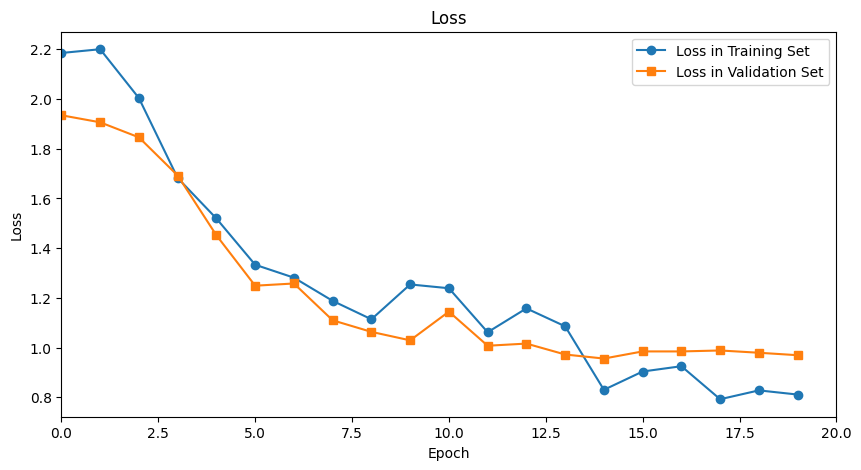

In [12]:
# plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss_train)), loss_train, label='Loss in Training Set', marker='o')
plt.plot(range(len(loss_val)), loss_val, label='Loss in Validation Set', marker='s')

plt.title('Loss')
plt.xlabel('Epoch')
plt.xlim(0,len(loss_train))
plt.ylabel('Loss')

plt.legend()

plt.show()

In [13]:
# load test data
ic_surv_data_test=IC_SurvData(dev=device, data_file="ODE_NN_IC_Simu_testData.csv")

In [14]:
ic_surv_data_test.L /= ob_end
ic_surv_data_test.R /= ob_end
ic_surv_data_test.true_t /= ob_end

In [15]:
# parameter of true model
h0_lambda=0.01
h0_k=10

beta=pd.read_csv("ODE_NN_IC_Simu_trueBeta.csv").to_numpy()

In [16]:
num_subinterval=100 # intervals for integral

t_integral=torch.linspace(0, 1, num_subinterval+1).to(device)[1:] # use the right side of the sub-interval in integration

integral_results=[] # square error for every individual

t1 = time.time()
for x,l,r,true_t in ic_surv_data_test:

    # for one individual
    x_value=x
    L_time=l
    R_time=r

    # index for baseline S0
    index_S0=x_value.cpu().numpy()[4]

    init=torch.cat((torch.zeros(1, 1).to(device), true_t.view(1, 1).to(device), x_value.repeat(1, 1)), dim=1).to(device)

    # cumulative hazard and survival function, estimated
    cum_hazard=odeint(net, init.to(device), t = torch.cat((torch.tensor([0.]).to(device),t_integral), dim=0).to(device))[1:,0,0].detach().cpu().clone().numpy()
    survivial_func=np.exp(-cum_hazard)

    # calculate survival function based on the known model
    true_t_integral=np.arange(num_subinterval)/num_subinterval*L_time.cpu().numpy()*ob_end
    true_t_integral=true_t_integral.astype(float)
    S0=np.exp(-h0_lambda*np.power(true_t_integral,h0_k*(1-0.5*index_S0)))
    index_func=np.power(S0,np.exp(sum(beta[0]*x_value.cpu().numpy().astype(float))+(x_value.cpu().numpy()[0])*(x_value.cpu().numpy()[0])+(x_value.cpu().numpy()[1])*(x_value.cpu().numpy()[1])+(x_value.cpu().numpy()[2])*(x_value.cpu().numpy()[3])))

    integral_results.append(float(sum(np.square(index_func-survivial_func))/num_subinterval))

print(time.time()-t1)

1/1000*sum(integral_results) # MSE

83.73352861404419


0.03394972226964097